In [1]:
import numpy as np
import matplotlib.pyplot as plt
from _tests import scripts
from scripts.notebook_utils import *
import os
import copy
import re
from ruamel.yaml import YAML

## Architectural Overview

This work is an architectural-level analysis of an optical tensor processor (OTP), inspired by the model proposed in https://arxiv.org/abs/2503.24356. The model is adapted to accelerate full-scale convolutional neural networks. A diagram of the architecture's dataflow is shown below (with some hardcoded optical constraints to be explained below):

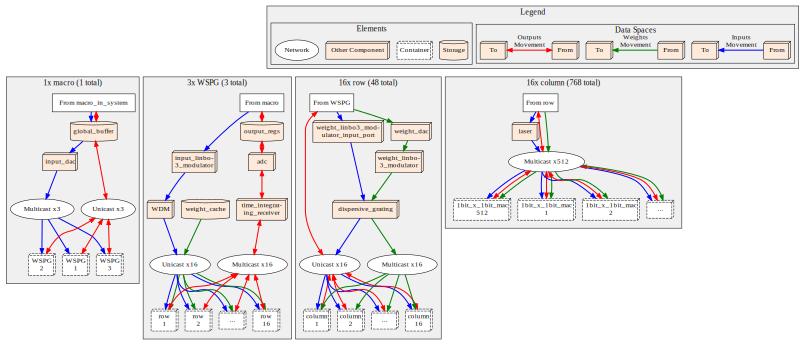

In [2]:
display_diagram(get_diagram("otp_2025", ignore=DIAGRAM_DEFAULT_IGNORE))

At the top (macro) level, the accelerator includes a global buffer to store inputs and outputs. The input Digital-to-Analog Converter (DAC) converts digital input data, which is multicasted down to the weight-stationary photonic group (WSPG) level.

Within the WSPG level, input light data is modulated using LiNbO3 electro-optic-modulators (EOMs), which is wave-division multiplexed and fanned-out to weight EOMs. Within the weight EOMs, the input light is doubled modulated (photonic multiplication). Weight data is transferred from the pre-loaded weight cache. Next, a dispersive grating, $f(\theta ') = f(\theta, \lambda)$, routes the double-modulated light to coalescing time integrating receivers (photonic accumulation). The outputs of the time integrating receivers are converted using an ADC and stored within output registers.

Note that the laser is set within the column level to ensure its power scales with the accelerator's computations.

The full yaml file is displayed below:

In [3]:
display_yaml_file("/home/workspace/models/arch/1_macro/otp_2025/arch.yaml")

```yaml
{{include_text('defines.yaml')}}

architecture:
  nodes: &macro # TOP MACRO
  # ===========================================================================
  - !Container # Macro top-level
    name: macro
    <<<: [*container_defaults]
    attributes:
      technology: TECHNOLOGY

  - !Component # Global buffer stores inputs operands.
    name: global_buffer
    <<<: [*component_defaults]
    subclass: albireo_sram
    attributes:
      depth: round(32768 * GLB_DEPTH_SCALE)
      width: 128
      n_banks: 32
      datawidth: 1
    constraints: 
      dataspace: {keep_only: [Inputs, Outputs]}
      temporal: 
        factors_only: [M=-1, C=-1, P=-1, Q=-1, N=-1, R=-1, S=-1]
        factors: []
        no_iteration_over_dataspaces: !nomerge [] # Overwrite default
        permutation: [N, P, Q, M, C, R, S] # Weight stationary

  - !Component # DAC supplies analog input values.
    name: input_dac
    <<<: [*component_defaults, *keep_inputs, *no_coalesce]
    subclass: dac_albireo
    attributes: {width: ENCODED_INPUT_BITS}

  - !Container # Tile contains weight cache and works on one set of outputs
    name: WSPG
    <<<: [*container_defaults]
    spatial: {meshX: N_WSPG}
    constraints:
      spatial:
        no_reuse: [Outputs, Weights]
        no_iteration_over_dataspaces: [Inputs]
        maximize_dims: [[M]]
    
  - !Component # LiNbO3 electro-optic modulator modulates input light using the values from the input dac.
    name: input_linbo3_modulator
    subclass: albireo_mzm
    <<<: [*component_defaults, *keep_inputs, *no_temporal_reuse]
    attributes: {width: ENCODED_INPUT_BITS, n_instances: 16}

  - !Component # Weight cache stores weights.
    name: weight_cache
    <<<: [*component_defaults, *keep_weights]
    subclass: albireo_sram
    attributes:
      depth: 4096
      width: 64
      datawidth: 8               # To ensure that we can run weight-stationary
      multiple_buffering: 0.0001 # (as assumed in the Albireo paper)
    constraints: 
      temporal: 
        factors_only: [M=-1]
        factors: []
        no_iteration_over_dataspaces: !nomerge [] # Overwrite default

  - !Component # Output buffer stores outputs.
    name: output_regs
    <<<: [*component_defaults, *keep_outputs]
    subclass: albireo_sram
    attributes: {depth: 1, width: 16, datawidth: 1}
    constraints: 
      dataspace: {keep_only: [Outputs]}

  - !Component # ADC
    name: adc
    <<<: [*component_defaults, *keep_outputs, *no_temporal_reuse]
    subclass: adc
    attributes: {<<<: *cim_component_attributes}

  - !Component # The time integrating receiver CAN coalesce outputs.
    name: time_integrating_receiver
    <<<: [*component_defaults, *keep_outputs, *no_temporal_reuse]
    subclass: albireo_tia
    attributes: {width = 64, n_instances = N_ADC_PER_BANK}

  - !Component # Passive wave-division multiplexer which uses a free-space grating.
    name: WDM
    <<<: [*component_defaults, *keep_inputs, *no_temporal_reuse]
    subclass: albireo_awg
    attributes: 
      width: ENCODED_INPUT_BITS

  - !ArrayContainer # Each row works on a different column of the filter weights.
    name: row
    <<<: [*container_defaults, *spatial_must_reuse_outputs]
    spatial: {meshY: 16} #Should be N_ROWS, but pre-filled to fix a bug.
    
  - !Component # DAC supplies analog weight values.
    name: weight_dac
    <<<: [*component_defaults, *keep_weights, *no_coalesce]
    subclass: dac_albireo
    attributes: {width: ENCODED_WEIGHT_BITS}

  - !Component # This LiNbO3 electro-optic modulator modulates light using the values from the weight dac. The light is now double-modulated (multiplied input and weight). Modify the subclasses of the two ports for seperate energy per port.
    name: weight_linbo3_modulator
    subclass: albireo_mzm
    <<<: [*component_defaults, *keep_weights, *no_temporal_reuse]
    attributes: {width: ENCODED_WEIGHT_BITS, n_instances: 16}
  - !Component 
    name: weight_linbo3_modulator_input_port
    subclass: albireo_mzm
    <<<: [*component_defaults, *keep_inputs, *no_temporal_reuse]
    attributes: {width: ENCODED_WEIGHT_BITS}

  - !Component #Route data, f(\theta, \lambda)
    name: dispersive_grating
    subclass: albireo_awg
    <<<: [*component_defaults, *keep_inputs, *keep_weights, *no_coalesce]
    attributes: {width: ENCODED_INPUT_BITS}

  - !ArrayContainer # Each column works on a different output. We try to have different columns work on different
                    # Ps in the output so that we can get input reuse among neighboring rows (over which we map R).
    name: column
    <<<: [*container_defaults, *spatial_must_reuse_weights]
    spatial: {meshX: 16} #Should be N_COLUMNS, but pre-filled to fix a bug.

  - !Component # Put laser down here -> power is proportional to the number of endpoints, same laser used as alberio.
    name: laser
    <<<: [*component_defaults, *keep_inputs, *no_coalesce]
    subclass: albireo_laser
    attributes:
      width: ENCODED_INPUT_BITS
      power_gated_at: "global_buffer" # Laser is on or off for the whole chip

  - !Hierarchical           # Virtualize an XxYxZ-bit MAC as multiple MAC units.
    nodes: *virtualized_mac # Defined in include/defines.yaml.```

## Setting Architectural-Specific Variables

The following optical hardware constraints can be varied:
- N_spatial_channels, corresponding to the WDM
- N_wavelengths, corresponding to the WDM
- N_fanouts, corresponding to the fanout factor

In [4]:
# Define optical hardware constraints

N_spatial_channels = 8 # Vary
N_wavelengths = 8 # Vary
assert(N_spatial_channels == N_wavelengths) # Optical constraint

N_fanouts = 2 #vary

# Architectural constraints

ENCODED_OUTPUT_BITS = 8 # Default, used for math

N_ROWS = N_spatial_channels
N_COLUMNS = N_fanouts

N_input_modulators = N_spatial_channels * N_fanouts
N_weight_modulators = N_input_modulators # Optical constraint

output_reg_width = ENCODED_OUTPUT_BITS * N_COLUMNS
time_integrating_receiver_width = ENCODED_OUTPUT_BITS * N_ROWS

N_WSPG = 3 # Vary

print(f"Number of spatial channels: {N_spatial_channels}, number of wavelengths: {N_wavelengths}, number of fanouts: {N_fanouts}")
print(f"Output regs width: {output_reg_width}, time integrating receiver width: {time_integrating_receiver_width}")
print(f"Number input/weight EOMs: {N_input_modulators}")

Number of spatial channels: 8, number of wavelengths: 8, number of fanouts: 2
Output regs width: 16, time integrating receiver width: 64
Number input/weight EOMs: 16


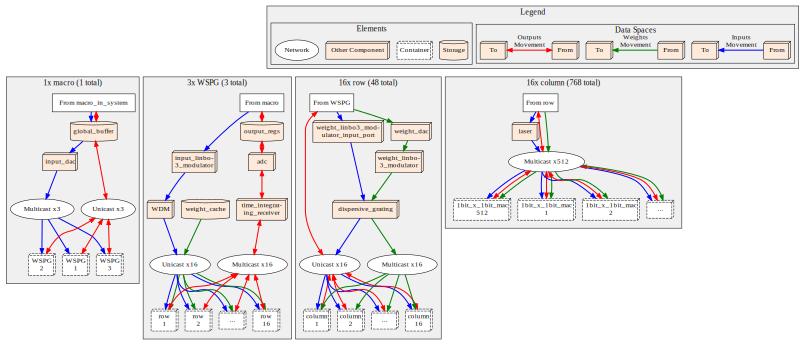

In [5]:
# Hacks to change the yaml files, if doubtful about the changes, check timeloop-mapper.flattened_architecture.yaml

yaml = YAML()

free_variables_filepath = "/home/workspace/models/arch/1_macro/otp_2025/variables_free.yaml" # Should route to variables_free.yaml file

with open(free_variables_filepath, 'r') as f:
    data = yaml.load(f)

data['variables']['N_COLUMNS'] = N_ROWS
data['variables']['N_ROWS'] = N_COLUMNS
data['variables']['N_WSPG'] = N_WSPG

with open(free_variables_filepath, 'w') as f:
    yaml.dump(data, f)

main_filepath = "/home/workspace/models/arch/1_macro/otp_2025/arch.yaml" # Should route to main arch.yaml file

with open(main_filepath, 'r') as f:
    arch_str = f.read()

# Use regex for pattern replacements
patterns_replacements = [
    (r'(name:\s*input_linbo3_modulator[\s\S]*?attributes:\s*\{[\s\S]*?n_instances\s*:\s*)\d+', 
     rf'\g<1>{N_input_modulators}'),

    (r'(name:\s*weight_linbo3_modulator[\s\S]*?attributes:\s*\{[\s\S]*?n_instances\s*:\s*)\d+', 
     rf'\g<1>{N_weight_modulators}'),

    (r'(name:\s*output_regs[\s\S]*?attributes:\s*\{[\s\S]*?width\s*[:=]\s*)\d+', 
     rf'\g<1>{output_reg_width}'),
    
    (r'(name:\s*time_integrating_receiver[\s\S]*?attributes:\s*\{[\s\S]*?width\s*=\s*)\d+', 
     rf'\g<1>{time_integrating_receiver_width}'),
]

# Apply pattern replacements
arch_str_modified = arch_str
for pattern, replacement in patterns_replacements:
    arch_str_modified = re.sub(pattern, replacement, arch_str_modified)

# Write back modified
with open(main_filepath, 'w') as f:
    f.write(arch_str_modified)

display_diagram(get_diagram("otp_2025", ignore=DIAGRAM_DEFAULT_IGNORE))

## Area Breakdown

Note that the area of the architecture is only an estimation, using values from Albireo (ISCA 2021).

In [6]:
results = quick_run("otp_2025")

total_area_otp = results.area*1e12
print(f"Total Area (um^2): {total_area_otp:.2f}")

output dir: /home/workspace/scripts/../outputs/10265.140737476156288
Total Area (um^2): 74805861.83


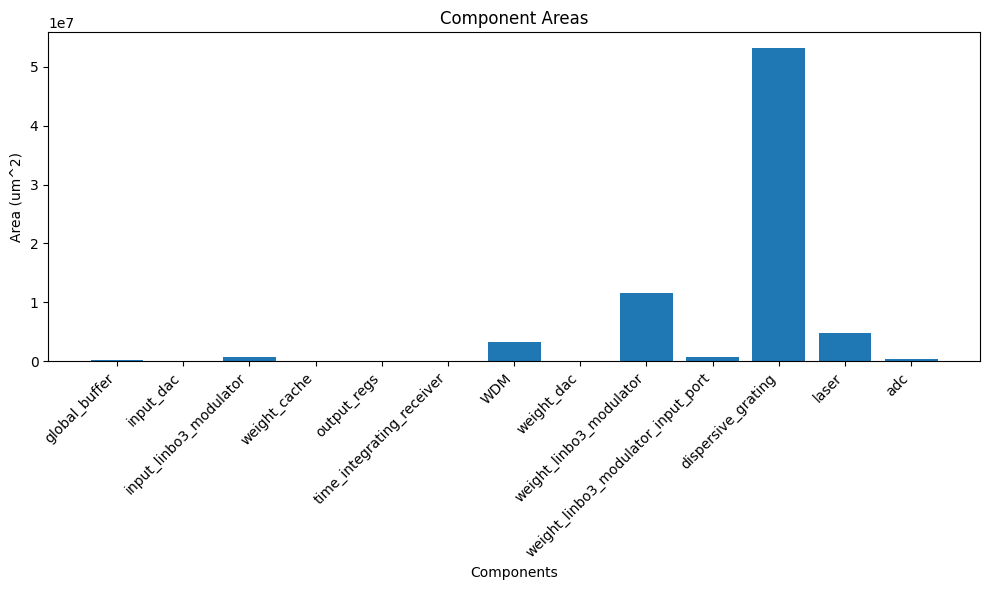

In [7]:
all_components = set()
areas = []

results.clear_zero_areas()

for component in results.per_component_area:
    all_components.add(component)
    area = results.per_component_area[component]
    areas.append(area*1e12)

plt.figure(figsize=(10, 6))
bars = plt.bar(results.per_component_area.keys(), areas)

plt.xlabel('Components')
plt.ylabel('Area (um^2)')
plt.title('Component Areas')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

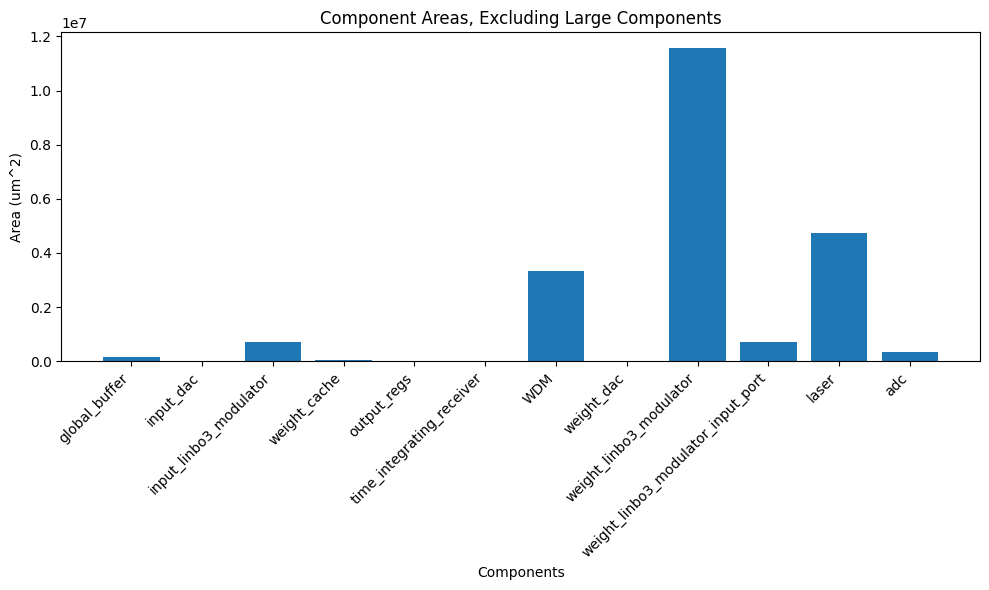

In [8]:
width = 0.35

all_components = set()
areas = []
filtered_components = []

# Components to exclude
exclude_components = {'dispersive_grating'}

results.clear_zero_areas()

for component in results.per_component_area:
    all_components.add(component)
    area = results.per_component_area[component]
    
    if component not in exclude_components:
        areas.append(area*1e12)
        filtered_components.append(component)

plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_components, areas)

plt.xlabel('Components')
plt.ylabel('Area (um^2)')
plt.title('Component Areas, Excluding Large Components')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

As expected, the optical components dominate the accelerator's area.

## Running CNN Layers on the Architecture

In [9]:
def run_layer(
    macro: str,
    layer: str,
    variables: dict = None,
    callfunc: Callable = None,
    iso: str = None,
    tile=None,
    chip=None,
    system="ws_dummy_buffer_many_macro",
):
    spec = get_spec(
        macro=macro, iso=iso, layer=layer, tile=tile, chip=chip, system=system
    )
    spec.architecture.name2leaf("macro").attributes["has_power_gating"] = True

    variables = variables or {}

    spec.variables.update(variables)
    for k in list(spec.variables.keys()):
        if k not in variables:
            spec.variables[k] = spec.variables.pop(k)

    if callfunc is not None:
        callfunc(spec)

    try:
        return run_mapper(spec=spec)
    except Exception as e:
        print(f"Error processing spec with {macro}, {iso}, {layer}, {variables}")
        raise e

We'll run a few select layers on resnet18 as an example (this can take a very long time to run, depending on the optical constraints).

In [10]:
# List of layers to run
layers = ["resnet18/00", "resnet18/01", "resnet18/05", "resnet18/08", "resnet18/10"]

# Run layers in parallel
results_otp_2025 = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(run_layer)("otp_2025", layer) for layer in layers
)

## Energy and Throughput Visualization

In [11]:
tops_per_layer_otp = []
total_energy_per_layer_otp = []
compute_density_per_layer_otp = []
energy_efficiency_per_layer_otp = []

for result, layer in zip(results_otp_2025, layers):
    tops_per_layer_otp.append(result.tops)
    total_energy_per_layer_otp.append(result.energy*1e12)
    compute_density_per_layer_otp.append(result.tops_per_mm2)
    energy_efficiency_per_layer_otp.append(result.tops_per_w)

Text(0, 0.5, 'Throughput (TOPS)')

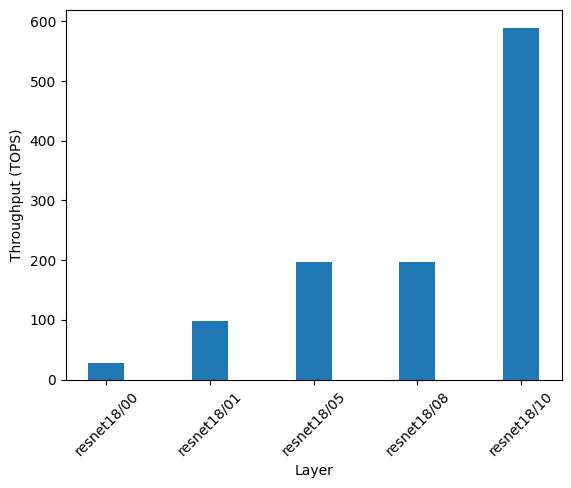

In [12]:
width = 0.35

fig, ax = plt.subplots()

plt.bar(np.arange(len(tops_per_layer_otp)), tops_per_layer_otp, width=width)
ax.set_xticks(np.arange(len(tops_per_layer_otp)))
ax.set_xticklabels(layers, rotation=45)
plt.xlabel("Layer")
plt.ylabel("Throughput (TOPS)")

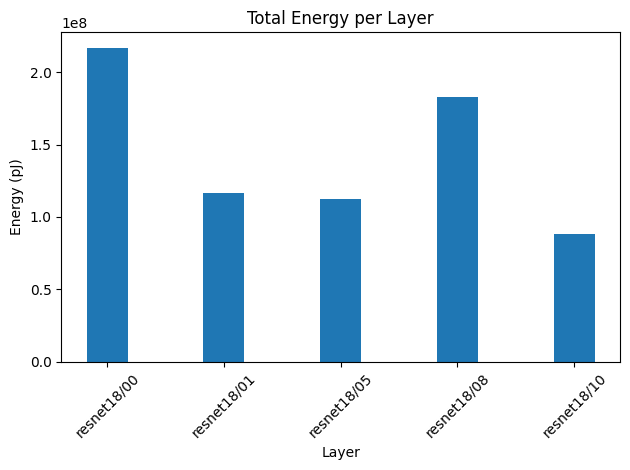

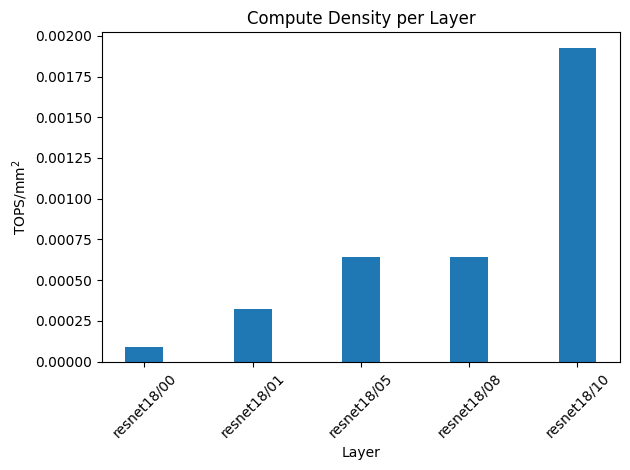

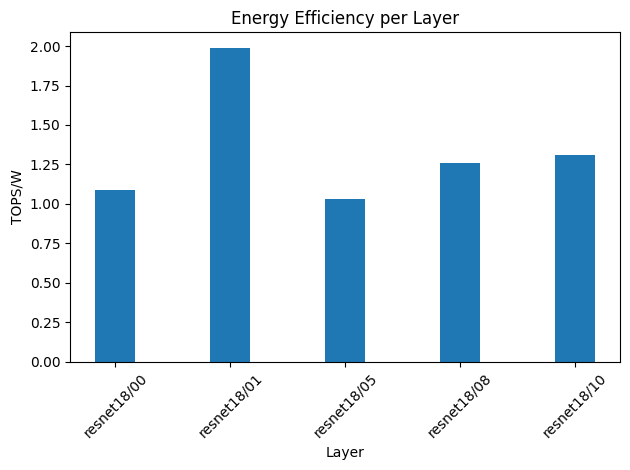

In [13]:
width = 0.35

plt.figure()
plt.bar(np.arange(len(total_energy_per_layer_otp)), total_energy_per_layer_otp, width=width)
plt.title('Total Energy per Layer')
plt.xlabel('Layer')
plt.ylabel('Energy (pJ)')
plt.xticks(np.arange(len(total_energy_per_layer_otp)), layers, rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(np.arange(len(compute_density_per_layer_otp)), compute_density_per_layer_otp, width=width)
plt.title('Compute Density per Layer')
plt.xlabel('Layer')
plt.ylabel(r'TOPS/mm$^2$')
plt.xticks(np.arange(len(compute_density_per_layer_otp)), layers, rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(np.arange(len(energy_efficiency_per_layer_otp)), energy_efficiency_per_layer_otp, width=width)
plt.title('Energy Efficiency per Layer')
plt.xlabel('Layer')
plt.ylabel('TOPS/W')
plt.xticks(np.arange(len(energy_efficiency_per_layer_otp)), layers, rotation=45)
plt.tight_layout()
plt.show()

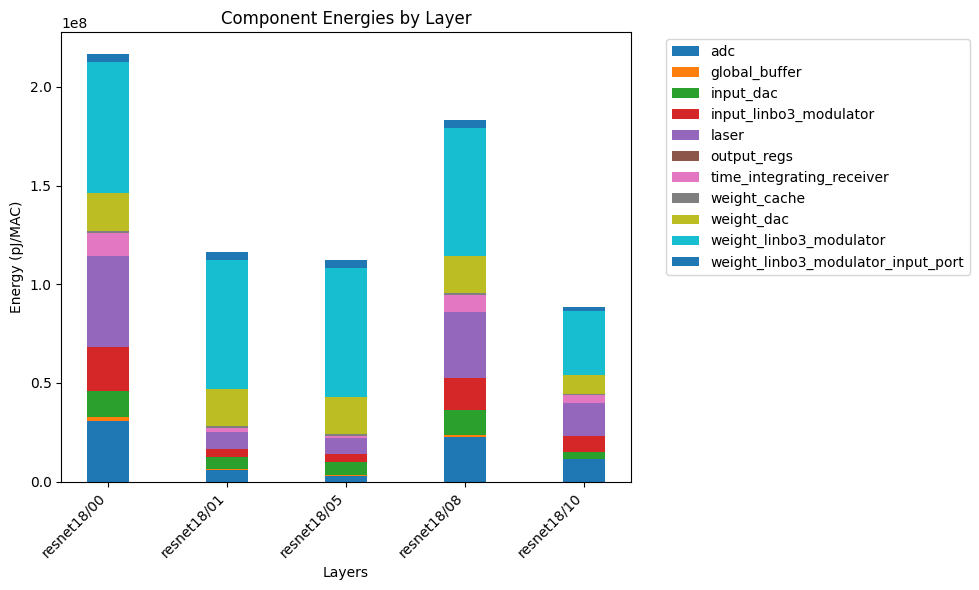

In [14]:
width = 0.35

all_components = set()
for result in results_otp_2025:
    result.clear_zero_energies()
    all_components.update(result.per_component_energy.keys())

all_components = sorted(all_components)

component_energies = {comp: [] for comp in all_components}

for result in results_otp_2025:
    for comp in all_components:
        energy = result.per_component_energy.get(comp, 0)
        component_energies[comp].append(energy * 1e12) # Convert to pJ

plt.figure(figsize=(10, 6))

bottom = np.zeros(len(results_otp_2025))

for comp in all_components:
    energies = component_energies[comp]
    plt.bar(layers, energies, label=comp, bottom=bottom, width=width)
    bottom += np.array(energies)

plt.xlabel('Layers')
plt.ylabel('Energy (pJ/MAC)')
plt.title('Component Energies by Layer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Comparison to Albireo (ISCA 2021)

Let's now compare the OTP architecture to "Albireo: Energy-Efficient Acceleration of Convolutional Neural Networks via Silicon Photonics," from https://ieeexplore.ieee.org/document/9499746. See "Architecture-Level Modeling of Photonic Deep Neural Network Accelerators," from https://arxiv.org/abs/2405.07266 for more details on the CiMLoop implementation.

In [15]:
# Hack to load in results of all the above tests on Albireo from the pre-run csv file

total_area_albireo = None
tops_per_layer_albireo = []
total_energy_per_layer_albireo = []
compute_density_per_layer_albireo = []
energy_efficiency_per_layer_albireo = []
all_albireo_components = []
layer_00_energies = []
layer_01_energies = []
layer_05_energies = []
layer_08_energies = []
layer_10_energies = []

with open("/home/workspace/models/arch/1_macro/otp_2025/albireo_tests.csv", 'r') as file:
    lines = file.readlines()
    
    total_area_albireo = float(lines[0].strip())
    # print(f"Total area: {total_area_albireo}")
    tops_per_layer_albireo = eval(lines[1].strip())
    # print(f"Tops per layer: {tops_per_layer_albireo}")
    total_energy_per_layer_albireo = eval(lines[2].strip())
    # print(f"Total energy per layer: {total_energy_per_layer_albireo}")
    compute_density_per_layer_albireo = eval(lines[3].strip())
    # print(f"Compute density per layer: {compute_density_per_layer_albireo}")
    energy_efficiency_per_layer_albireo = eval(lines[4].strip())
    # print(f"Energy efficiency per layer: {energy_efficiency_per_layer_albireo}")
    all_albireo_components = eval(lines[5].strip())
    # print(f"All albireo components: {all_albireo_components}")

In [16]:
print(f"Albireo is {total_area_albireo / total_area_otp} times larger.")

Albireo is 1.6747985803942054 times larger.


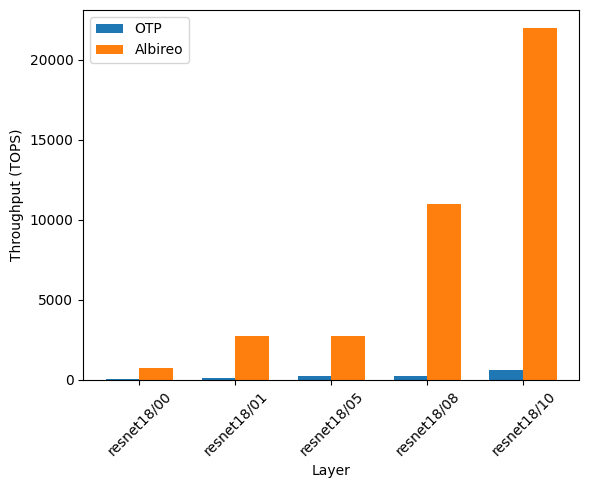

In [17]:
assert(len(tops_per_layer_otp) == len(tops_per_layer_albireo))

fig, ax = plt.subplots()

x = np.arange(len(tops_per_layer_otp))
width = 0.35

rects1 = ax.bar(x - width/2, tops_per_layer_otp, width, label='OTP')
rects2 = ax.bar(x + width/2, tops_per_layer_albireo, width, label='Albireo')

ax.set_xticks(x)
ax.set_xticklabels(layers, rotation=45)
plt.xlabel("Layer")
plt.ylabel("Throughput (TOPS)")
plt.legend()

plt.show()

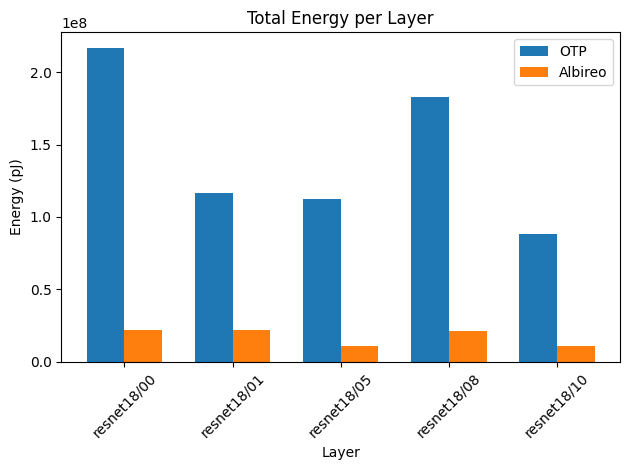

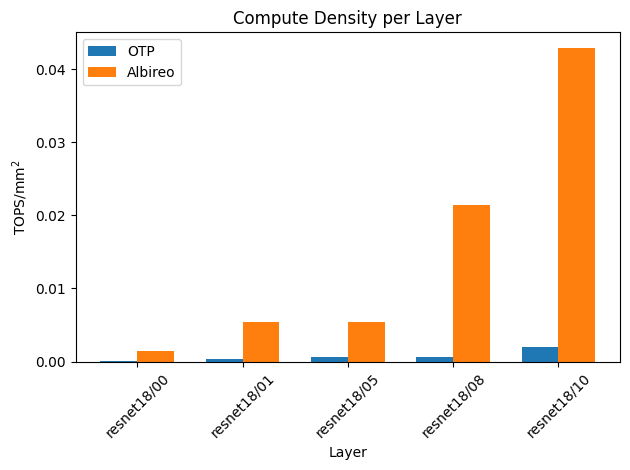

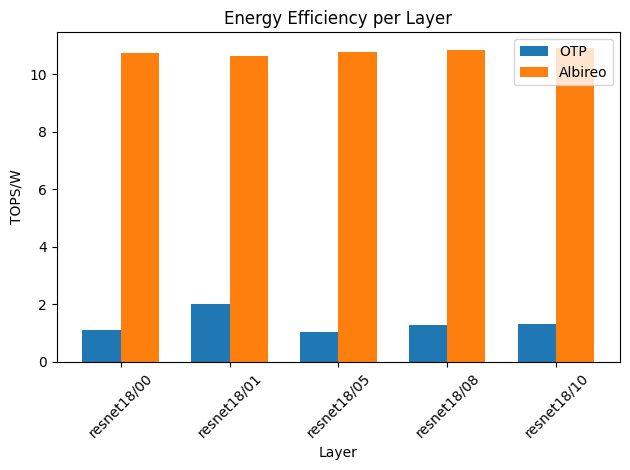

output dir: /home/workspace/scripts/../outputs/10320.140737476156288
output dir: /home/workspace/scripts/../outputs/10315.140737476156288
output dir: /home/workspace/scripts/../outputs/10317.140737476156288
output dir: /home/workspace/scripts/../outputs/10319.140737476156288


In [18]:
assert(len(total_energy_per_layer_otp) == len(total_energy_per_layer_albireo))
assert(len(compute_density_per_layer_otp) == len(compute_density_per_layer_albireo))
assert(len(energy_efficiency_per_layer_otp) == len(energy_efficiency_per_layer_albireo))

x = np.arange(len(total_energy_per_layer_otp))
width = 0.35

plt.figure()
plt.bar(x - width/2, total_energy_per_layer_otp, width, label='OTP')
plt.bar(x + width/2, total_energy_per_layer_albireo, width, label='Albireo')
plt.title('Total Energy per Layer')
plt.xlabel('Layer')
plt.ylabel('Energy (pJ)')
plt.xticks(x, layers, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(x - width/2, compute_density_per_layer_otp, width, label='OTP')
plt.bar(x + width/2, compute_density_per_layer_albireo, width, label='Albireo')
plt.title('Compute Density per Layer')
plt.xlabel('Layer')
plt.ylabel(r'TOPS/mm$^2$')
plt.xticks(x, layers, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(x - width/2, energy_efficiency_per_layer_otp, width, label='OTP')
plt.bar(x + width/2, energy_efficiency_per_layer_albireo, width, label='Albireo')
plt.title('Energy Efficiency per Layer')
plt.xlabel('Layer')
plt.ylabel('TOPS/W')
plt.xticks(x, layers, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()